# Import bibliotek

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import AgglomerativeClustering
import warnings
warnings.filterwarnings('ignore')

# Pobranie i przetwarzanie danych

## Wczytanie danych, zamiana statusu, grupowanie

In [2]:
#wczytanie surowych danych
orders = pd.read_csv("zam_dane.csv")
#przygotowanie funkcji zmieniającej status z tekstu na znacznik 1/0 
def is_cancel(x):
    if x == 'Wprowadzone':
        return 0
    else:
        return 1
#zamiana statusu, zgrupowanie danych, usunięcie duplikatów
orders["is_cancel"] = orders["status"].apply(is_cancel)
orders=orders[["nr_zamowienia","is_cancel","ilosc"]].groupby(by=["nr_zamowienia","is_cancel"]).sum().reset_index()
orders = orders[["is_cancel","ilosc"]].drop_duplicates()
#przygotowanie danych do modelu
X = orders[['ilosc']].to_numpy()
y = orders[['is_cancel']].to_numpy()

## Dalsza analiza i obróbka danych

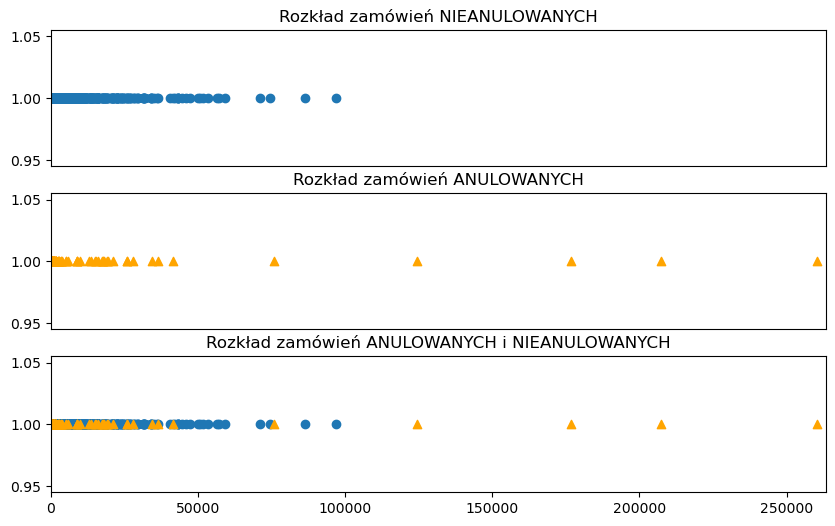

In [3]:
#Rozkład zamówień NIEANULOWANYCH/ANULOWANYCH wg ilości
x_max = X.max() +3000
f, (ax1, ax2, ax3) = plt.subplots(nrows=3,ncols=1, figsize=(10,6))
ax1.scatter(X[y.reshape(-1)==0,0],np.ones(X[y.reshape(-1)==0,0].shape),marker='o')
ax1.set_title("Rozkład zamówień NIEANULOWANYCH")
ax1.set_xlim([0, x_max])
ax1.get_xaxis().set_visible(False)
ax2.scatter(X[y.reshape(-1)==1,0],np.ones(X[y.reshape(-1)==1,0].shape),marker='^', c = ['orange'])
ax2.set_title("Rozkład zamówień ANULOWANYCH")
ax2.set_xlim([0, x_max])
ax2.get_xaxis().set_visible(False)
ax3.scatter(X[y.reshape(-1)==0,0],np.ones(X[y.reshape(-1)==0,0].shape),marker='o')
ax3.scatter(X[y.reshape(-1)==1,0],np.ones(X[y.reshape(-1)==1,0].shape),marker='^', c = ['orange'])
ax3.set_title("Rozkład zamówień ANULOWANYCH i NIEANULOWANYCH")
ax3.set_xlim([0, x_max])
plt.savefig('chart1.png')

## Klasyfikacja zamówień wewnątrz oryginalnych klas

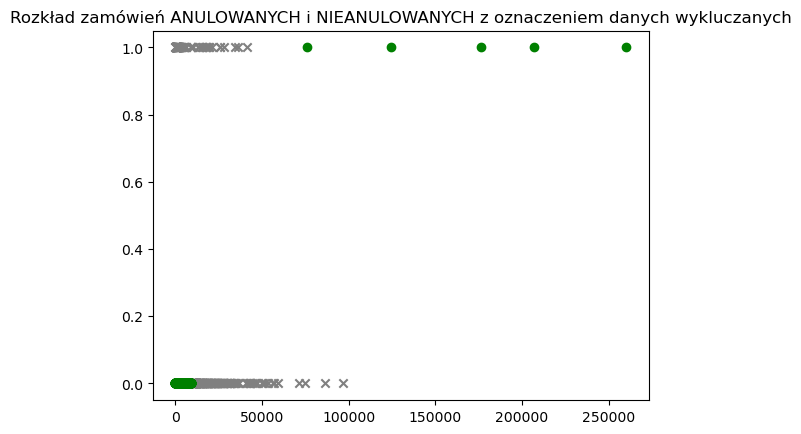

In [4]:
#Klasy podstawowe można spróbować podzielić na kolejne podklasy, aby poprawić jakość danych

#zamówienia NIEANULOWANE klasyfikacja na 2 grupy z użyciem AgglomerativeClustering 
#(NIEANULOWANE - poprawnie / NIEANULOWANE - jeszcze nie zauważono błądu)
orders_not_canceled = X[y.reshape(-1)==0,0]
agg_clustering = AgglomerativeClustering(n_clusters=2)
agg_clustering.fit(orders_not_canceled.reshape(-1, 1))

plt.scatter(orders_not_canceled[agg_clustering.labels_==0],np.zeros(orders_not_canceled[agg_clustering.labels_==0].shape) 
            ,marker='x', c = ['grey'])
plt.scatter(orders_not_canceled[agg_clustering.labels_==1],np.zeros(orders_not_canceled[agg_clustering.labels_==1].shape) 
            ,marker='o', c = ['green'])
#zamówienia ANULOWANE klasyfikacja na 2 grupy z użyciem AgglomerativeClustering 
#(ANULOWANE - poprawnie / ANULOWANE - z innych przyczyn niż błędna ilość)
orders_canceled = X[y.reshape(-1)==1,0]
agg_clustering2 = AgglomerativeClustering(n_clusters=2)
agg_clustering2.fit(orders_canceled.reshape(-1, 1))

plt.scatter(orders_canceled[agg_clustering2.labels_==0],np.ones(orders_canceled[agg_clustering2.labels_==0].shape) 
            ,marker='o', c = ['green'])
plt.scatter(orders_canceled[agg_clustering2.labels_==1],np.ones(orders_canceled[agg_clustering2.labels_==1].shape) 
            ,marker='x', c = ['grey'] )
plt.title("Rozkład zamówień ANULOWANYCH i NIEANULOWANYCH z oznaczeniem danych wykluczanych")
plt.savefig('chart2.png')

## Stworzenie finalnego zestawu danych

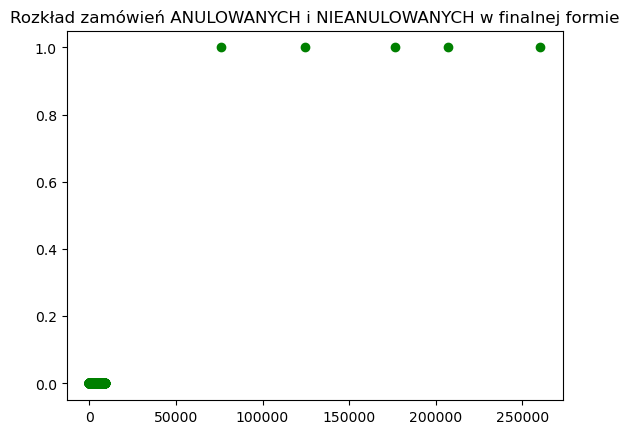

In [5]:
#stworzenie zamówień NIEANULOWANYCH z wykluczeniem grupy wartości mogących wymagać anulowania
orders_not_canceled_values = orders_not_canceled[agg_clustering.labels_==1].reshape(1,-1)
orders_not_canceled_labels = np.zeros(orders_not_canceled[agg_clustering.labels_==1].shape).reshape(1,-1)
X_orders_not_canceled = np.concatenate((orders_not_canceled_values,orders_not_canceled_labels), axis=0)
#stworzenie zamówień ANULOWANYCH z wykluczeniem grupy wartości mogących być anulowanymi ze wzglądu nie na ilość
orders_canceled_values = orders_canceled[agg_clustering2.labels_==0].reshape(1,-1)
orders_canceled_labels = np.ones(orders_canceled[agg_clustering2.labels_==0].shape).reshape(1,-1)
X_orders_canceled = np.concatenate((orders_canceled_values,orders_canceled_labels), axis=0)     
#połączenie zestawów danych
X_orders = np.concatenate((X_orders_not_canceled, X_orders_canceled), axis=1)
#przygotowanie danych do modelu
X = X_orders[0,:].reshape(-1, 1)
y = X_orders[1,:].reshape(-1, 1)
plt.scatter(X,y,marker='o', c = ['green'])
plt.title("Rozkład zamówień ANULOWANYCH i NIEANULOWANYCH w finalnej formie")
plt.savefig('chart3.png')

## Użycie regresji logistycznej do wyznaczenia progu, od którego zamówienie może być do anulowania

In [6]:
#stworzenie modelu i dopasowanie go do całości danych
log_r = LogisticRegression()
log_r.fit(X,y)
#definicja funkcji zwracającej próg przejścia pomiędzy klasami 0/1
def model_threshold(model):
    i = 0
    while model.predict([[i]]) == 0:
        i += 1 
    return i
#wydrukowanie progu
th = model_threshold(log_r)
print("Wyznaczony próg, po którym zamówienie może być błędne to {}".format(th))

Wyznaczony próg, po którym zamówienie może być błędne to 45886


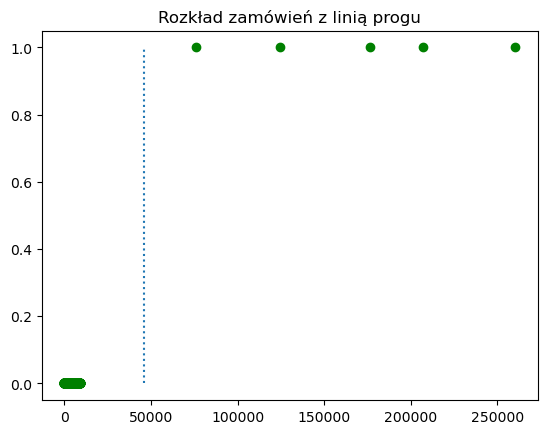

In [7]:
#graficzna prezentacja danych i progu
th_line = np.full((50), th)
th_x = np.linspace(0,1)
#definicja wykresu
plt.scatter(X,y,marker='o', c = ['green'])
plt.plot(th_line,th_x, ':')
plt.title("Rozkład zamówień z linią progu")
plt.savefig('chart4.png')